In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score
import pickle
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Import data and visualize the distribution

In [3]:
#load the data
data = pd.read_csv('supermarket_sales.csv')
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
# check if the data is missing any values and datatypes in dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Total                    1000 non-null   float64
 9   Date                     1000 non-null   object 
 10  Time                     1000 non-null   object 
 11  Payment                  1000 non-null   object 
 12  cogs                     1000 non-null   float64
 13  gross margin percentage  1000 non-null   float64
 14  gross income             

### Infer: Since there are no empty values we do not have to fill any null values.

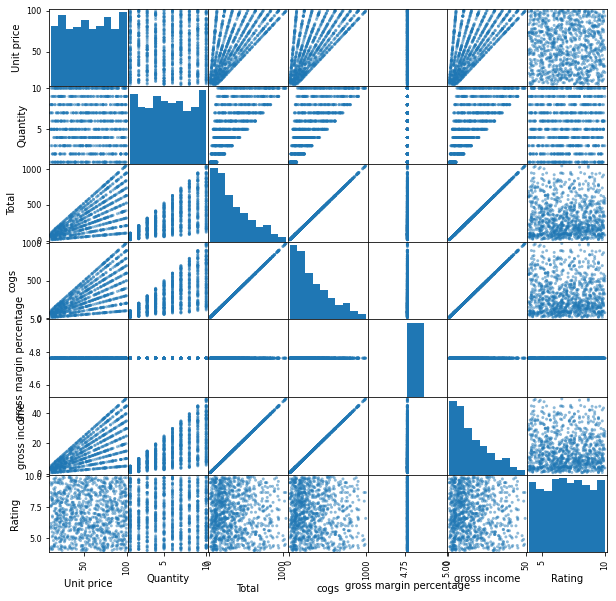

In [5]:
from pandas.plotting import scatter_matrix

scatter_matrix(data,figsize=(10,10));

In [6]:
unique_values = {col: data[col].unique() for col in data.columns}

# Print the unique values for each column
for col, values in unique_values.items():
    print(f"Column: {col}")
    print(f"Number of Unique values: {values.size}\n")

Column: Invoice ID
Number of Unique values: 1000

Column: Branch
Number of Unique values: 3

Column: City
Number of Unique values: 3

Column: Customer type
Number of Unique values: 2

Column: Gender
Number of Unique values: 2

Column: Product line
Number of Unique values: 6

Column: Unit price
Number of Unique values: 943

Column: Quantity
Number of Unique values: 10

Column: Total
Number of Unique values: 990

Column: Date
Number of Unique values: 89

Column: Time
Number of Unique values: 506

Column: Payment
Number of Unique values: 3

Column: cogs
Number of Unique values: 990

Column: gross margin percentage
Number of Unique values: 1

Column: gross income
Number of Unique values: 990

Column: Rating
Number of Unique values: 61



- From unique values of each columns,
    * Since 'Gross margin percentage' column has same values for all entries, we can remove the column.
    * We can remove the 'Invoice ID' column as well, as it is containes different values for different entries and it will not be helpful for model selection and training with too many distinct values.
    * Remove 'City' or 'Branch' column as well as they both represent same value in different notation.

In [7]:
data.drop(columns=['City', 'Invoice ID','gross margin percentage'], inplace=True)

### 1. Date and Time Encoding:
     - Extracting useful features like day of week and time slot helps to uncover patterns in sales related to specific times or days pattern.

In [8]:
def Day_of_week(X):
    return pd.to_datetime(X['Date']).dt.day_name().values.reshape(-1,1)

def Timeslot(X):
    def time_slot(time_str):
        hour = int(time_str.split(':')[0])
        if 10 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 19:
            return 'Evening'
        else:
            return 'Night'
    
    return pd.Series(X['Time']).apply(time_slot).values.reshape(-1,1)


### 2a. Multiple linear regression without Lasso regularization to predict 'gross income'

In [9]:
# Split the data into train_set and test_set based on stratification.
# Used {Branch,Product line,Payment} as stratification columns to represent the same ratio of distribution as original dataset.
X1 = data.drop(columns=['gross income'], axis=1)
t1 = data['gross income']

In [10]:
corr_matrix = data.corr(method='pearson', numeric_only=True)
corr_matrix

,Unit price,Quantity,Total,cogs,gross income,Rating
Unit price,1.000000,0.010778,0.633962,0.633962,0.633962,-0.008778
Quantity,0.010778,1.000000,0.705510,0.705510,0.705510,-0.015815
Total,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
cogs,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
gross income,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
Rating,-0.008778,-0.015815,-0.036442,-0.036442,-0.036442,1.000000


1. While predicting gross income, we have to exclude 'Total' and 'cogs' columns as well as these columns are highly correlated (correlation=1) which undermines the importance of other features. To find out the impact of other features on prediction we have to exclude 'Total' and 'cogs' columns.

In [11]:
X1.drop(columns=['Total','cogs'],inplace=True)

**1. Train test split based on stratification of columns 'Gender', 'Branch', 'Product line' and 'Payment' to ensure the split is the same proportion as the original dataset.**

**2. Excluded 'Customer type' for stratification as this leads to very low cases in y.**


In [12]:
data['stratify_column'] = data['Gender'] +  '_' + data['Branch'] + '_' + data['Product line'] + '_' + data['Payment'] 
X1_train, X1_test,t1_train,t1_test= train_test_split(X1, t1, test_size=0.2, random_state=1, shuffle=True, stratify=data['stratify_column'])
data.drop(columns=['stratify_column'],inplace=True)
X1_train.shape,X1_test.shape

((800, 10), (200, 10))

In [13]:
date_feature = ['Date']
time_feature = ['Time']
num_cat_data = X1_train.drop(columns=['Date','Time']) #to exclude date and time features of other features
num_features = [col for col in num_cat_data.columns if num_cat_data[col].dtype != "object"]
cat_features = [col for col in num_cat_data.columns if num_cat_data[col].dtype == "object"]
print("Categorical features:",cat_features)
print("Numerical features:",num_features)

Categorical features: ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']
Numerical features: ['Unit price', 'Quantity', 'Rating']


In [14]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()) 
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
])


date_pipeline = Pipeline([
    ('DayofWeek', FunctionTransformer(Day_of_week)),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


time_pipeline = Pipeline([
    ('Timeslot', FunctionTransformer(Timeslot)),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])


In [15]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),  # Process numeric features
    ('cat', cat_pipeline, cat_features),  # Process categorical features
    ('date', date_pipeline, date_feature),  # Process the 'Date' column
    ('time', time_pipeline, time_feature)  # Process the 'Time' column
])

In [16]:
lr_pipeline = Pipeline([
     ('preprocessor',full_pipeline),
     ('lin_reg', LinearRegression())
])

model1_lr=lr_pipeline.fit(X1_train,t1_train)
model1_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unit price', 'Quantity',
                                                   'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('date',
                                                  Pipeline(steps=[('DayofWeek',
                                                                   FunctionTransformer(func=<function Day_of_week at 0x15377e53f880>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Date']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('lin_reg', LinearRegression())])

### 2b.Multiple linear regression with Lasso regularization to predict 'gross income'

In [17]:
lasso_pipeline = Pipeline([
    ('preprocessor',full_pipeline),
    ('regressor',Lasso())
])

param_grid_lasso = {
    'regressor__alpha':np.linspace(0.001,0.2,1000)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)#Use best kfold cross validation
lasso_grid = GridSearchCV(lasso_pipeline,param_grid=param_grid_lasso,cv=kf,scoring='r2')
lasso_grid.fit(X1_train,t1_train)
best_params_grid_search_poly_lasso = lasso_grid.best_params_
print("Best hyperparamaters for GridsearchCV for Linear Regression with lasso:", best_params_grid_search_poly_lasso)

Best hyperparamaters for GridsearchCV for Linear Regression with lasso: {'regressor__alpha': 0.15776976976976978}


In [18]:
model1_lasso = Pipeline([
    ('preprocessor',full_pipeline),
    ('regressor',Lasso(alpha= best_params_grid_search_poly_lasso['regressor__alpha']))
]).fit(X1_train,t1_train)
model1_lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unit price', 'Quantity',
                                                   'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('date',
                                                  Pipeline(steps=[('DayofWeek',
                                                                   FunctionTransformer(func=<function Day_of_week at 0x15377e53f880>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Date']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('regressor', Lasso(alpha=0.15776976976976978))])

### Impact of features on models ability to predict 'Gross income'

In [19]:
#To check how gross income is affected by unit price, quantity, and other variables like day, time slot, and product line.
date_feature_names = list(full_pipeline.transformers_[2][1].named_steps['encoder'].get_feature_names_out(date_feature))
time_feature_names = list(full_pipeline.transformers_[3][1].named_steps['encoder'].get_feature_names_out(time_feature))
num_feature_names = num_features  # Since num_features is predefined
cat_feature_names = full_pipeline.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features)

In [20]:
coefficients = lr_pipeline.named_steps['lin_reg'].coef_
feature_names = np.concatenate([
    num_feature_names,  
    cat_feature_names,  
    date_feature_names,  
    time_feature_names  
])
coef_df = pd.DataFrame({'Feature name': feature_names, 'Coefficient value': coefficients})
coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefiiceints of linear regression")
# Display sorted coefficients by absolute value
coef_df

Coefiiceints of linear regression


,Feature name,Coefficient value,AbsCoefficient
1,Quantity,8.126293,8.126293
0,Unit price,7.269379,7.269379
24,Date_Tuesday,0.574926,0.574926
25,Date_Wednesday,-0.566977,0.566977
17,Payment_Credit card,0.432963,0.432963
21,Date_Saturday,0.351029,0.351029
20,Date_Monday,-0.286998,0.286998
14,Product line_Home and lifestyle,0.283939,0.283939
28,Time_Morning,-0.268838,0.268838
5,Branch_C,0.242520,0.242520


In [21]:
coefficients = model1_lasso.named_steps['regressor'].coef_
feature_names = np.concatenate([
    num_feature_names, 
    cat_feature_names, 
    date_feature_names, 
    time_feature_names 
])
coef_df = pd.DataFrame({'Feature name': feature_names, 'Coefficient value': coefficients})
coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefiiceints of linear regression with lasso")
# Display sorted coefficients by absolute value
coef_df

Coefiiceints of linear regression with lasso


,Feature name,Coefficient value,AbsCoefficient
1,Quantity,7.981798,7.981798
0,Unit price,7.093737,7.093737
28,Time_Morning,-0.000000,0.000000
27,Time_Evening,0.000000,0.000000
26,Time_Afternoon,0.000000,0.000000
25,Date_Wednesday,-0.000000,0.000000
24,Date_Tuesday,0.000000,0.000000
23,Date_Thursday,-0.000000,0.000000
22,Date_Sunday,0.000000,0.000000
21,Date_Saturday,0.000000,0.000000


In [22]:
with open('model1_lr.pkl','wb') as f:
    pickle.dump(model1_lr,f)
with open('model1_lasso.pkl','wb') as f:
    pickle.dump(model1_lasso,f)    
with open('X1_test.pkl', 'wb') as f:
    pickle.dump(X1_test, f)
with open('t1_test.pkl', 'wb') as f:
    pickle.dump(t1_test, f)

**1. How is the gross income affected by unit price, quantity, and other variables like day, time slot, and product line in general?**
* In the model linear regression without lasso, it is observed from the coefficients of features that, gross income is most affected by Quantity followed closely by Unit price. As long as quantity or unit price increases, gross income also increases. Related to day,time slot and product line, gross income is highly affetced by 'Tuesday', 'Product line_Home and lifestyle' and 'Time_Morning' slots the highest in these respective categories.
* In the model linear regression with lasso, lasso regularization parameter removes the influence of all the factors except Quantity and Unit price. These two features only affect the gross income.

### 3a. Multiple linear regression to predict unit price without lasso regularization

In [23]:
X2 = data.drop(columns=['Unit price'], axis=1)
t2 = data['Unit price']
X2.head()

,Branch,Customer type,Gender,Product line,Quantity,Total,Date,Time,Payment,cogs,gross income,Rating
0,A,Member,Female,Health and beauty,7,548.9715,1/5/2019,13:08,Ewallet,522.83,26.1415,9.1
1,C,Normal,Female,Electronic accessories,5,80.2200,3/8/2019,10:29,Cash,76.40,3.8200,9.6
2,A,Normal,Male,Home and lifestyle,7,340.5255,3/3/2019,13:23,Credit card,324.31,16.2155,7.4
3,A,Member,Male,Health and beauty,8,489.0480,1/27/2019,20:33,Ewallet,465.76,23.2880,8.4
4,A,Normal,Male,Sports and travel,7,634.3785,2/8/2019,10:37,Ewallet,604.17,30.2085,5.3


In [24]:
corr2= data.corr(method='pearson',numeric_only=True)
corr2

,Unit price,Quantity,Total,cogs,gross income,Rating
Unit price,1.000000,0.010778,0.633962,0.633962,0.633962,-0.008778
Quantity,0.010778,1.000000,0.705510,0.705510,0.705510,-0.015815
Total,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
cogs,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
gross income,0.633962,0.705510,1.000000,1.000000,1.000000,-0.036442
Rating,-0.008778,-0.015815,-0.036442,-0.036442,-0.036442,1.000000


No need to exclude any extra column as their presence doesnot overshadow the other features impact on models performance.

In [25]:
data['stratify_column'] = data['Gender'] +  '_' + data['Branch'] + '_' + data['Product line'] + '_' + data['Payment'] 
X2_train, X2_test,t2_train,t2_test= train_test_split(X2, t2, test_size=0.2, random_state=1, shuffle=True, stratify=data['stratify_column'])
data.drop(columns=['stratify_column'],inplace=True)
X2_train.shape,X2_test.shape

((800, 12), (200, 12))

In [26]:
date_feature2 = ['Date']
time_feature2 = ['Time']
num_cat_data2 = X2_train.drop(columns=['Date','Time']) #to exclude date and time features of other features
num_features2 = [col for col in num_cat_data2.columns if num_cat_data2[col].dtype != "object"]
cat_features2 = [col for col in num_cat_data2.columns if num_cat_data2[col].dtype == "object"]
print("Categorical features:",cat_features2)
print("Numerical features:",num_features2)

Categorical features: ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']
Numerical features: ['Quantity', 'Total', 'cogs', 'gross income', 'Rating']


In [27]:
full_pipeline2 = ColumnTransformer([
    ('num', num_pipeline, num_features2), 
    ('cat', cat_pipeline, cat_features2),
    ('date', date_pipeline, date_feature2),
    ('time', time_pipeline, time_feature2)
])

In [28]:
lr_pipeline2 = Pipeline([
     ('preprocessor',full_pipeline2),
     ('lin_reg', LinearRegression())
])

model2_lr=lr_pipeline2.fit(X2_train,t2_train)
model2_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Quantity', 'Total', 'cogs',
                                                   'gross income', 'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('date',
                                                  Pipeline(steps=[('DayofWeek',
                                                                   FunctionTransformer(func=<function Day_of_week at 0x15377e53f880>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Date']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('lin_reg', LinearRegression())])

### 3b. Multiple linear regression to predict unit price with lasso regularization

In [29]:
lasso_pipeline = Pipeline([
    ('preprocessor',full_pipeline2),
    ('regressor',Lasso())
])

param_grid_lasso = {
    'regressor__alpha':np.linspace(0.1,0.5,1000)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_grid = GridSearchCV(lasso_pipeline,param_grid=param_grid_lasso,cv=kf,scoring='r2')
lasso_grid.fit(X2_train,t2_train)
best_params_grid_search_poly_lasso = lasso_grid.best_params_
print("Best hyperparamaters for GridsearchCV for Linear Regression with lasso:", best_params_grid_search_poly_lasso)

Best hyperparamaters for GridsearchCV for Linear Regression with lasso: {'regressor__alpha': 0.2881881881881882}


In [30]:
model2_lasso = Pipeline([
    ('preprocessor',full_pipeline2),
    ('regressor',Lasso(alpha= best_params_grid_search_poly_lasso['regressor__alpha']))
]).fit(X2_train,t2_train)
model2_lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Quantity', 'Total', 'cogs',
                                                   'gross income', 'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('date',
                                                  Pipeline(steps=[('DayofWeek',
                                                                   FunctionTransformer(func=<function Day_of_week at 0x15377e53f880>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Date']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('regressor', Lasso(alpha=0.2881881881881882))])

### Impact of features on models ability to predict 'Unit price'

In [31]:
date_feature2_names = list(full_pipeline.transformers_[2][1].named_steps['encoder'].get_feature_names_out(date_feature2))
time_feature2_names = list(full_pipeline.transformers_[3][1].named_steps['encoder'].get_feature_names_out(time_feature2))
num_feature2_names = num_features2  # Since num_features is predefined
cat_feature2_names = full_pipeline2.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features2)

In [32]:
coefficients = lr_pipeline2.named_steps['lin_reg'].coef_
feature_names = np.concatenate([
    num_feature2_names,
    cat_feature2_names,
    date_feature2_names,
    time_feature2_names
])
coef_df = pd.DataFrame({'Feature name': feature_names, 'Coefficient value': coefficients})
coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefiiceints of linear regression")
# Display sorted coefficients by absolute value
coef_df

Coefiiceints of linear regression


,Feature name,Coefficient value,AbsCoefficient
0,Quantity,-23.374382,23.374382
1,Total,11.079626,11.079626
2,cogs,11.079626,11.079626
3,gross income,11.079626,11.079626
26,Date_Tuesday,-2.260858,2.260858
22,Date_Monday,1.629256,1.629256
19,Payment_Credit card,-1.487510,1.487510
27,Date_Wednesday,1.412690,1.412690
30,Time_Morning,1.275701,1.275701
28,Time_Afternoon,-1.116084,1.116084


In [33]:
coefficients = model2_lasso.named_steps['regressor'].coef_
feature_names = np.concatenate([
    num_feature2_names,
    cat_feature2_names,
    date_feature2_names,
    time_feature2_names
])
coef_df = pd.DataFrame({'Feature name': feature_names, 'Coefficient value': coefficients})
coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefiiceints of linear regression with lasso")
# Display sorted coefficients by absolute value
coef_df

Coefiiceints of linear regression with lasso


,Feature name,Coefficient value,AbsCoefficient
1,Total,32.244177,32.244177
0,Quantity,-22.425996,22.425996
19,Payment_Credit card,-0.756274,0.756274
26,Date_Tuesday,-0.107249,0.107249
4,Rating,0.078173,0.078173
28,Time_Afternoon,-0.072728,0.072728
30,Time_Morning,0.000000,0.000000
29,Time_Evening,-0.000000,0.000000
27,Date_Wednesday,0.000000,0.000000
17,Product line_Sports and travel,-0.000000,0.000000


In [34]:
with open('model2_lr.pkl','wb') as f:
    pickle.dump(model2_lr,f)
    
with open('model2_lasso.pkl','wb') as f:
    pickle.dump(model2_lasso,f)
   
with open('X2_test.pkl', 'wb') as f:
    pickle.dump(X2_test, f)

with open('t2_test.pkl', 'wb') as f:
    pickle.dump(t2_test, f)    
    

**1. How is the unit price affected by gross income, quantity, and other variables like day, timeslot, and product line in general?**
* In the model linear regression without lasso, unit price is affected the most by 'Quantity' followed by 'Total','cogs','gross income' equally. in the categoreis day, timeslot, and product line, unit price is most affected on Tuesday, Morning and Fashion accessories repectively.
* In model linear regression with lasso, Unit price is most affected by 'Total' and followed by 'Quantity'. Using Lasso regularization reduces the weights of most of the features but the affect by Tuesday and Afternoon categories exist is small weights.

## 4. Logistic regression to classify gender

In [35]:
## Use logistic regression to study the relationship between gender, product line, payment and gross income for branch C
# To classify Gender, Use 1 to represent male and 0 to represent to represent non_male(female)

In [36]:
data_branch_C = data[data['Branch']=='C']
X3= data_branch_C.drop(columns=['Gender','Branch'])
t3 = data_branch_C['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

X3_train,X3_test,t3_train,t3_test = train_test_split(X3,t3,test_size=0.2, random_state=1, shuffle=True,stratify=t3)
X3_train.shape,X3_test.shape

((262, 11), (66, 11))

In [37]:
date_feature3 = ['Date']
time_feature3 = ['Time']
num_cat_data3 = X3_train.drop(columns=['Date','Time']) #to exclude date and time features of other features
num_features3 = [col for col in num_cat_data3.columns if num_cat_data3[col].dtype != "object"]
cat_features3 = [col for col in num_cat_data3.columns if num_cat_data3[col].dtype == "object"]
print("Categorical features:",cat_features3)
print("Numerical features:",num_features3)

Categorical features: ['Customer type', 'Product line', 'Payment']
Numerical features: ['Unit price', 'Quantity', 'Total', 'cogs', 'gross income', 'Rating']


In [38]:
full_pipeline3 = ColumnTransformer([
    ('num', num_pipeline, num_features3),  # Process numeric features
    ('cat', cat_pipeline, cat_features3),  # Process categorical features
    ('date', date_pipeline, date_feature3),  # Process the 'Date' column
    ('time', time_pipeline, time_feature3)  # Process the 'Time' column
])
full_pipeline3

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Unit price', 'Quantity', 'Total', 'cogs',
                                  'gross income', 'Rating']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Customer type', 'Product line', 'Payment']),
                                ('date',
                                 Pipeline(steps=[('DayofWeek',
                                                  FunctionTransformer(func=<function Day_of_week at 0x15377e53f880>)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Date']),
                                ('time',
                                 Pipeline(steps=[('Timeslot',
                                                  FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Time'])])

In [39]:
interaction_pipeline = Pipeline([
    ('preprocessor', full_pipeline3),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))  # Interaction terms only
])

log_reg_pipeline = Pipeline([
    ('interaction', interaction_pipeline),
    ('log_reg', LogisticRegression(penalty=None,max_iter=10000))
])

In [40]:
param_grid={'log_reg__C':[0.01,0.1,1,10,100], 'log_reg__solver':['lbfgs','saga', 'liblinear']}
grid_search = GridSearchCV(log_reg_pipeline,param_grid,cv=10)
grid_search.fit(X3_train,t3_train)
best_param = grid_search.best_params_
print(best_param)

{'log_reg__C': 0.01, 'log_reg__solver': 'lbfgs'}


In [41]:
model3 = Pipeline([
    ('interaction',interaction_pipeline),
    ('log_reg',LogisticRegression(penalty=None, solver=best_param['log_reg__solver'],max_iter=10000,C = best_param['log_reg__C']))
])
model3.fit(X3_train,t3_train)

Pipeline(steps=[('interaction',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Unit '
                                                                    'price',
                                                                    'Quantity',
                                                                    'Total',
                                                                    'cogs',
                                                                    'gross '
                                                                    'income',
                                                                    'Rating']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Customer '
                                                                    'type',
                                                                    'Product '
                                                                    'line',
                                                                    'Payment']),
                                                                  ('date',
                                                                   Pipe...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Date']),
                                                                  ('time',
                                                                   Pipeline(steps=[('Timeslot',
                                                                                    FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Time'])])),
                                 ('poly',
                                  PolynomialFeatures(include_bias=False,
                                                     interaction_only=True))])),
                ('log_reg',
                 LogisticRegression(C=0.01, max_iter=10000, penalty=None))])

In [42]:
cat_feature_names = list(full_pipeline3.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features3))
num_feature_names = num_features3
date_feature_names = list(full_pipeline3.transformers_[2][1].named_steps['encoder'].get_feature_names_out(date_feature3))
time_feature_names = list(full_pipeline3.transformers_[3][1].named_steps['encoder'].get_feature_names_out(time_feature3))
interaction_feature_names = interaction_pipeline.named_steps['poly'].get_feature_names_out(
    input_features=num_feature_names + cat_feature_names + date_feature_names + time_feature_names)
#Extract the coefficients from the trained logistic regression model
coefficients = model3.named_steps['log_reg'].coef_[0]

# Create a dataframe for feature names and coefficients
coef_df = pd.DataFrame({'Feature name': interaction_feature_names, 'Coefficient value': coefficients})

# Sort coefficients by absolute value to identify the most informative features
coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefficeints of logistic regression to classify gender")
# Display sorted coefficients by absolute value
coef_df

Coefficeints of logistic regression to classify gender


,Feature name,Coefficient value,AbsCoefficient
201,Customer type_Normal Product line_Sports and t...,-863.245115,863.245115
245,Product line_Fashion accessories Date_Sunday,-662.686730,662.686730
273,Product line_Health and beauty Payment_Credit ...,652.443479,652.443479
233,Product line_Electronic accessories Time_Morning,611.208800,611.208800
65,Quantity Product line_Home and lifestyle,-609.496929,609.496929
...,...,...,...
364,Date_Monday Date_Tuesday,0.000000,0.000000
315,Payment_Cash Payment_Credit card,0.000000,0.000000
175,Customer type_Member Customer type_Normal,0.000000,0.000000
370,Date_Saturday Date_Sunday,0.000000,0.000000


**2. Which attributes are the most informative?**

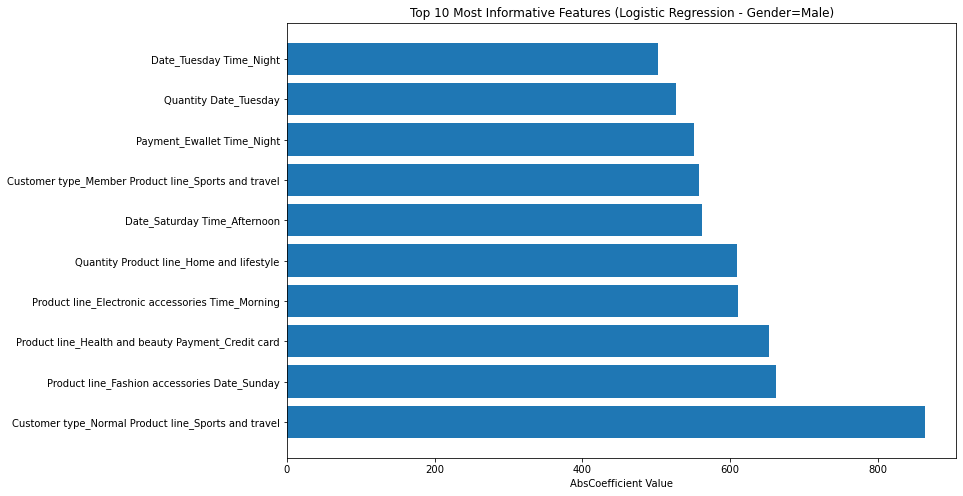

Top 10 Most Informative Features for Gender=Male classification:


,Feature name,Coefficient value,AbsCoefficient
201,Customer type_Normal Product line_Sports and t...,-863.245115,863.245115
245,Product line_Fashion accessories Date_Sunday,-662.686730,662.686730
273,Product line_Health and beauty Payment_Credit ...,652.443479,652.443479
233,Product line_Electronic accessories Time_Morning,611.208800,611.208800
65,Quantity Product line_Home and lifestyle,-609.496929,609.496929
374,Date_Saturday Time_Afternoon,561.429587,561.429587
181,Customer type_Member Product line_Sports and t...,557.383628,557.383628
350,Payment_Ewallet Time_Night,551.056433,551.056433
75,Quantity Date_Tuesday,-526.979850,526.979850
395,Date_Tuesday Time_Night,502.983010,502.983010


In [43]:
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature name'][:10], coef_df['AbsCoefficient'][:10])  # Top 10 most informative features
plt.xlabel('AbsCoefficient Value')
plt.title('Top 10 Most Informative Features (Logistic Regression - Gender=Male)')
plt.show()

# Print out the most informative features
print("Top 10 Most Informative Features for Gender=Male classification:")
coef_df.head(10)

In [44]:
with open('model3.pkl','wb') as f:
    pickle.dump(model3,f)
    
with open('X3_test.pkl', 'wb') as f:
    pickle.dump(X3_test, f)

with open('t3_test.pkl', 'wb') as f:
    pickle.dump(t3_test, f)
    

### 5. Logistic regression to classify Customer type

In [45]:
X4= data_branch_C.drop(columns=['Customer type','Branch'])
t4 = data_branch_C['Customer type'].apply(lambda x: 1 if x == 'Normal' else 0)

X4_train,X4_test,t4_train,t4_test = train_test_split(X4,t4,test_size=0.2, random_state=1, shuffle=True,stratify=t4)
X4_train.shape,X4_test.shape

((262, 11), (66, 11))

In [46]:
date_feature4 = ['Date']
time_feature4 = ['Time']
num_cat_data4 = X4_train.drop(columns=['Date','Time']) #to exclude date and time features of other features
num_features4 = [col for col in num_cat_data4.columns if num_cat_data4[col].dtype != "object"]
cat_features4 = [col for col in num_cat_data4.columns if num_cat_data4[col].dtype == "object"]
print("Categorical features:",cat_features4)
print("Numerical features:",num_features4)

Categorical features: ['Gender', 'Product line', 'Payment']
Numerical features: ['Unit price', 'Quantity', 'Total', 'cogs', 'gross income', 'Rating']


In [47]:
full_pipeline4 = ColumnTransformer([
    ('num', num_pipeline, num_features4),  # Process numeric features
    ('cat', cat_pipeline, cat_features4),  # Process categorical features
    ('date', date_pipeline, date_feature4),  # Process the 'Date' column
    ('time', time_pipeline, time_feature4)  # Process the 'Time' column
])

In [48]:
interaction_pipeline2 = Pipeline([
    ('preprocessor', full_pipeline4),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))  # Interaction terms only
])

log_reg_pipeline2 = Pipeline([
    ('interaction', interaction_pipeline2),
    ('log_reg', LogisticRegression(penalty=None,max_iter=10000))
])

In [49]:
param_grid={'log_reg__C':[0.01,0.1,1,10,100], 'log_reg__solver':['lbfgs','saga', 'liblinear']}
grid_search = GridSearchCV(log_reg_pipeline2,param_grid,cv=10)
grid_search.fit(X4_train,t4_train)
best_param = grid_search.best_params_
print(best_param)

{'log_reg__C': 0.01, 'log_reg__solver': 'lbfgs'}


In [50]:
model4 = Pipeline([
    ('interaction',interaction_pipeline2),
    ('log_reg',LogisticRegression(penalty=None, solver=best_param['log_reg__solver'],max_iter=10000,C = best_param['log_reg__C']))
])
model4.fit(X4_train,t4_train)

Pipeline(steps=[('interaction',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Unit '
                                                                    'price',
                                                                    'Quantity',
                                                                    'Total',
                                                                    'cogs',
                                                                    'gross '
                                                                    'income',
                                                                    'Rating']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Gender',
                                                                    'Product '
                                                                    'line',
                                                                    'Payment']),
                                                                  ('date',
                                                                   Pipeline(ste...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Date']),
                                                                  ('time',
                                                                   Pipeline(steps=[('Timeslot',
                                                                                    FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Time'])])),
                                 ('poly',
                                  PolynomialFeatures(include_bias=False,
                                                     interaction_only=True))])),
                ('log_reg',
                 LogisticRegression(C=0.01, max_iter=10000, penalty=None))])

In [51]:
#Extract the coefficients from the trained logistic regression model
coefficients = model4.named_steps['log_reg'].coef_[0]

cat_feature_names = list(full_pipeline4.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features4))
num_feature_names = num_features4
date_feature_names = list(full_pipeline4.transformers_[2][1].named_steps['encoder'].get_feature_names_out(date_feature4))
time_feature_names = list(full_pipeline4.transformers_[3][1].named_steps['encoder'].get_feature_names_out(time_feature4))
interaction_feature_names = interaction_pipeline2.named_steps['poly'].get_feature_names_out(
    input_features=num_feature_names + cat_feature_names + date_feature_names + time_feature_names)

# Create a dataframe for feature names and coefficients
coef_df = pd.DataFrame({'Feature name': interaction_feature_names, 'Coefficient value': coefficients})

coef_df['AbsCoefficient'] = coef_df['Coefficient value'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print("Coefficeints of logistic regression to classify Customer type")
# Display sorted coefficients by absolute value
coef_df

Coefficeints of logistic regression to classify Customer type


,Feature name,Coefficient value,AbsCoefficient
49,Unit price Date_Tuesday,-136.043526,136.043526
48,Unit price Date_Thursday,129.472702,129.472702
311,Product line_Sports and travel Time_Afternoon,-128.181779,128.181779
68,Quantity Payment_Credit card,-117.716967,117.716967
76,Quantity Date_Wednesday,-114.057021,114.057021
...,...,...,...
286,Product line_Home and lifestyle Product line_S...,0.000000,0.000000
378,Date_Sunday Date_Thursday,0.000000,0.000000
379,Date_Sunday Date_Tuesday,0.000000,0.000000
380,Date_Sunday Date_Wednesday,0.000000,0.000000


**2.Which attributes are the most informative?**

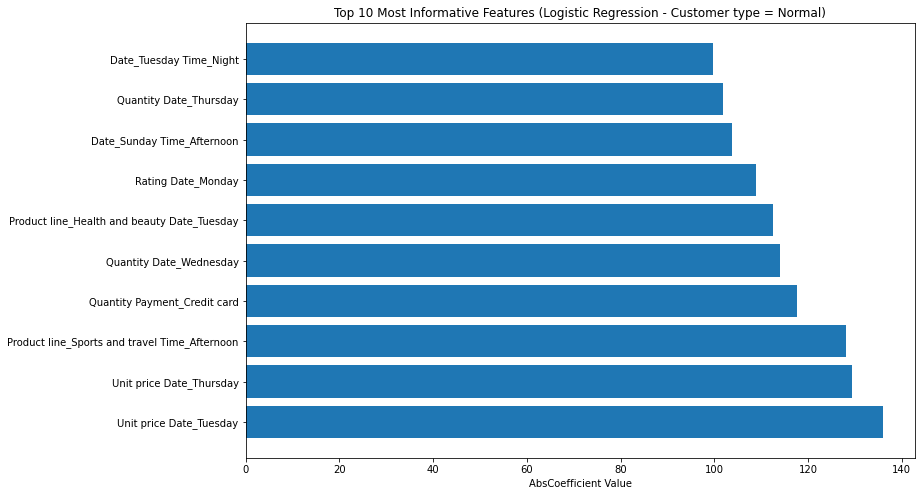

Top 10 Most Informative Features for Customer type = Normal classification:


,Feature name,Coefficient value,AbsCoefficient
49,Unit price Date_Tuesday,-136.043526,136.043526
48,Unit price Date_Thursday,129.472702,129.472702
311,Product line_Sports and travel Time_Afternoon,-128.181779,128.181779
68,Quantity Payment_Credit card,-117.716967,117.716967
76,Quantity Date_Wednesday,-114.057021,114.057021
280,Product line_Health and beauty Date_Tuesday,112.417962,112.417962
165,Rating Date_Monday,-108.865755,108.865755
381,Date_Sunday Time_Afternoon,-103.701788,103.701788
74,Quantity Date_Thursday,101.784768,101.784768
395,Date_Tuesday Time_Night,-99.711887,99.711887


In [52]:
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature name'][:10], coef_df['AbsCoefficient'][:10])  # Top 10 most informative features
plt.xlabel('AbsCoefficient Value')
plt.title('Top 10 Most Informative Features (Logistic Regression - Customer type = Normal)')
plt.show()

# Print out the most informative features
print("Top 10 Most Informative Features for Customer type = Normal classification:")
coef_df.head(10)

In [53]:
with open('model4.pkl','wb') as f:
    pickle.dump(model4,f)
   
with open('X4_test.pkl', 'wb') as f:
    pickle.dump(X4_test, f)

with open('t4_test.pkl', 'wb') as f:
    pickle.dump(t4_test, f)

## 6a. Classifiers to predict day of purchase
Classifier 1: Decision Tree classifier

In [54]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,make_scorer
from scipy import stats

In [55]:
X= data.copy()
X['DayofWeek'] = pd.to_datetime(X['Date']).dt.day_name()
X5 = X.drop(columns=['Date','DayofWeek'])
t5 = X['DayofWeek']
X5_train,X5_test,t5_train,t5_test = train_test_split(X5,t5,test_size=0.2,random_state=1,stratify=t5)
X5_train

,Branch,Customer type,Gender,Product line,Unit price,Quantity,Total,Time,Payment,cogs,gross income,Rating
646,C,Normal,Male,Health and beauty,70.21,6,442.3230,14:58,Cash,421.26,21.0630,7.4
561,C,Normal,Male,Food and beverages,89.20,10,936.6000,15:42,Credit card,892.00,44.6000,4.4
163,C,Normal,Male,Sports and travel,76.40,2,160.4400,19:42,Ewallet,152.80,7.6400,6.5
49,C,Member,Female,Fashion accessories,82.63,10,867.6150,17:08,Ewallet,826.30,41.3150,7.9
83,C,Member,Female,Food and beverages,80.36,4,337.5120,18:45,Credit card,321.44,16.0720,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...
559,A,Member,Female,Home and lifestyle,72.42,3,228.1230,16:54,Ewallet,217.26,10.8630,8.2
833,A,Member,Male,Health and beauty,91.30,1,95.8650,14:42,Ewallet,91.30,4.5650,9.2
784,C,Member,Female,Health and beauty,10.16,5,53.3400,13:08,Ewallet,50.80,2.5400,4.1
278,C,Member,Male,Fashion accessories,70.99,10,745.3950,16:28,Cash,709.90,35.4950,5.7


In [56]:
time_feature5 = ['Time']
num_cat_data5 = X5.drop(columns = ['Time']) 
num_features5 = [col for col in num_cat_data5.columns if num_cat_data5[col].dtype != "object"]
cat_features5 = [col for col in num_cat_data5.columns if num_cat_data5[col].dtype == "object"]
print("Numerical features:",num_features5)
print("Categorical features:",cat_features5)

Numerical features: ['Unit price', 'Quantity', 'Total', 'cogs', 'gross income', 'Rating']
Categorical features: ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']


In [57]:
full_pipeline5 = ColumnTransformer([
    ('num', num_pipeline, num_features5),  # Process numeric features
    ('cat', cat_pipeline, cat_features5),  # Process categorical features
    ('time', time_pipeline, time_feature5)  # Process the 'Time' column
])

In [58]:
decision_pipeline = Pipeline(steps=[
    ('preprocessor',full_pipeline5),
    ('classifier', DecisionTreeClassifier(random_state=1))
])

decision_param_grid = {
    'classifier__criterion':['gini','entropy'],
    'classifier__max_depth': [15, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2, 4, 6, 10]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(decision_pipeline,decision_param_grid,cv=kf,scoring='accuracy')
grid_search.fit(X5_train,t5_train)
best_param = grid_search.best_params_
print(best_param)

{'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 2}


**Using stratifiedKfold we can ensure the best Cross validation strategy and using GridsearchCV, we can find the best parameters for optimal performance.**

In [59]:
model5 = Pipeline([
    ('preprocessor',full_pipeline5),
    ('classifier',DecisionTreeClassifier(criterion=best_param['classifier__criterion'],max_depth=best_param['classifier__max_depth'],
                                         min_samples_leaf=best_param['classifier__min_samples_leaf'],min_samples_split= best_param['classifier__min_samples_split'],random_state=1))
])
model5.fit(X5_train,t5_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unit price', 'Quantity',
                                                   'Total', 'cogs',
                                                   'gross income', 'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=6,
                                        random_state=1))])

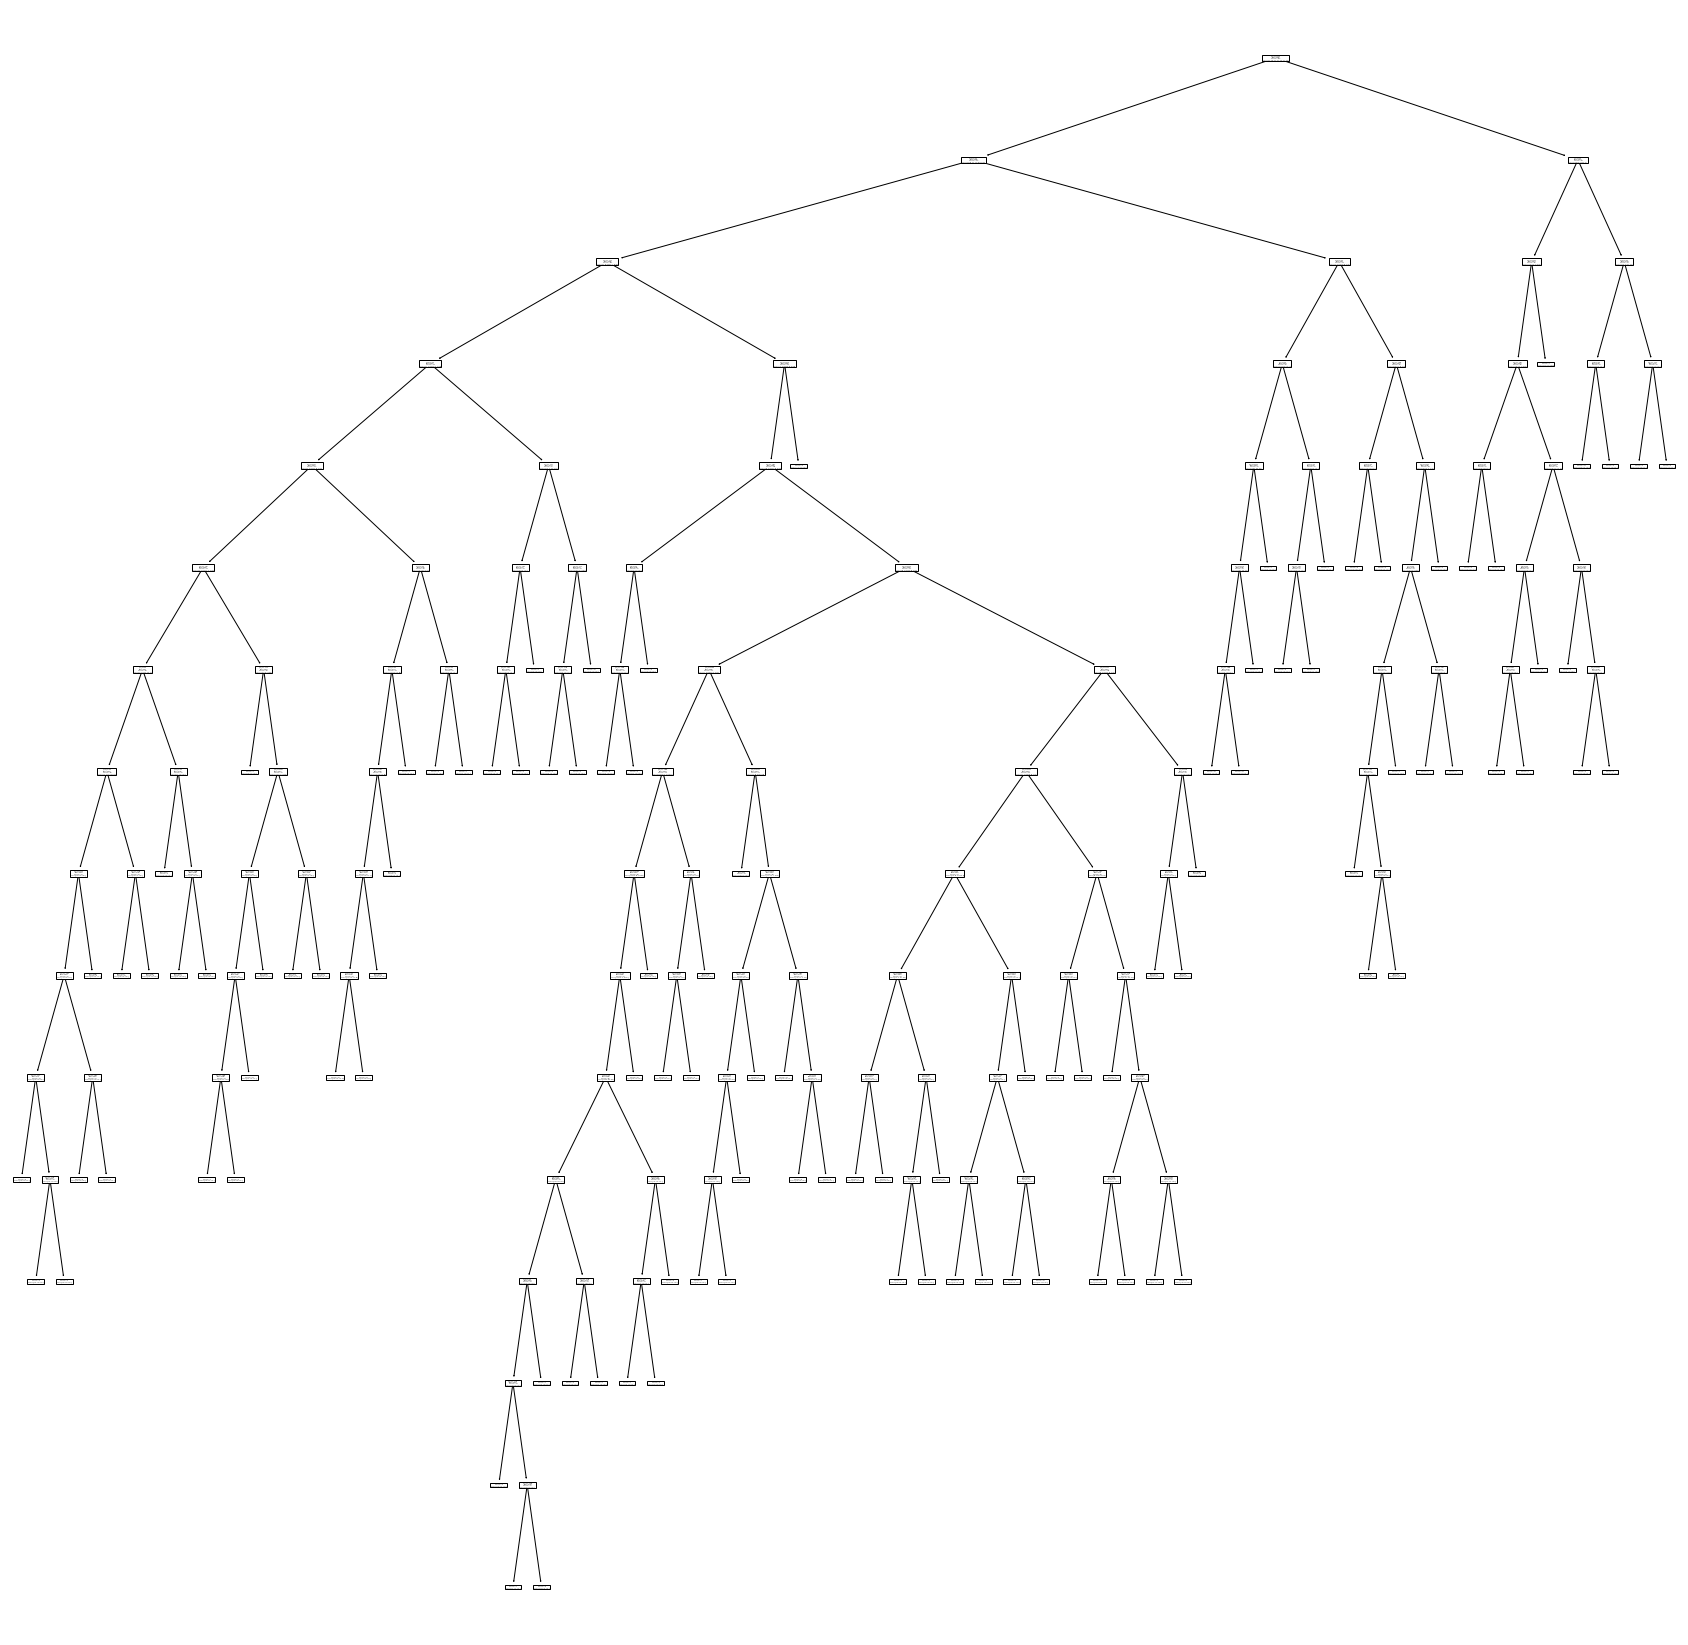

In [60]:
from sklearn.tree import plot_tree
tree_model = model5.named_steps['classifier']
plt.figure(figsize=(30,30))
plot_tree(tree_model)
plt.show()

In [61]:
with open('model5.pkl','wb') as f:
    pickle.dump(model5,f)
   
with open('X5_test.pkl', 'wb') as f:
    pickle.dump(X5_test, f)

with open('t5_test.pkl', 'wb') as f:
    pickle.dump(t5_test, f)

## 6b. Classifiers to predict day of purchase
2. Random Forest classifier

In [62]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', full_pipeline5),
    ('classifier', RandomForestClassifier(random_state=1))
])

rf_param_grid = {
    'classifier__criterion':['gini','entropy'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(rf_pipeline,rf_param_grid,cv=kf,scoring='accuracy')
grid_search.fit(X5_train,t5_train)
best_param = grid_search.best_params_
print(best_param)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


**Using stratifiedKfold we can ensure the best Cross validation strategy and using GridsearchCV, we can find the best parameters for optimal performance.**

In [63]:
model6 = Pipeline([
    ('preprocessor',full_pipeline5),
    ('classifier',RandomForestClassifier(n_estimators=best_param['classifier__n_estimators'],criterion=best_param['classifier__criterion'],
                                         max_depth=best_param['classifier__max_depth'], min_samples_split=best_param['classifier__min_samples_split'],
                                         min_samples_leaf=best_param['classifier__min_samples_leaf'], random_state=1))
])
model6.fit(X5_train,t5_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unit price', 'Quantity',
                                                   'Total', 'cogs',
                                                   'gross income', 'Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Branch', 'Customer type',
                                                   'Gender', 'Product line',
                                                   'Payment']),
                                                 ('time',
                                                  Pipeline(steps=[('Timeslot',
                                                                   FunctionTransformer(func=<function Timeslot at 0x15377e53f760>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time'])])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=2, n_estimators=50,
                                        random_state=1))])

In [64]:
with open('model6.pkl','wb') as f:
    pickle.dump(model6,f)